In [48]:
import streamlit as st
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import os
import cv2

In [51]:
# Using forward slashes
image_path = "C:/Users/PERIYASAMY/OneDrive/Documents/jananiphonepe/images"
faces_data = pd.read_csv("C:/Users/PERIYASAMY/OneDrive/Documents/jananiphonepe/faces (1).csv")

# Copy the dataframe
data = faces_data.copy()
print(data.head())


     image_name  width  height   x0   y0    x1   y1
0  00001722.jpg   1333    2000  490  320   687  664
1  00001044.jpg   2000    1333  791  119  1200  436
2  00001050.jpg    667    1000  304  155   407  331
3  00001736.jpg    626     417  147   14   519  303
4  00003121.jpg    626     418  462   60   599  166


In [85]:
# Check for duplicates
print("Number of duplicate rows:", data.duplicated().sum())

# Remove duplicate rows 
data = data.drop_duplicates()
print("Shape after removing duplicates:", data.shape)

# Check for null values 
print("Null values in each column:")
print(data.isnull().sum())




Number of duplicate rows: 0
Shape after removing duplicates: (3350, 7)
Null values in each column:
image_name    0
width         0
height        0
x0            0
y0            0
x1            0
y1            0
dtype: int64


In [54]:
#Full path of image
data["image_name"] = data["image_name"].apply(lambda x : os.path.join(image_path, x))
data.head()

,image_name,width,height,x0,y0,x1,y1
0,C:/Users/PERIYASAMY/OneDrive/Documents/jananip...,1333,2000,490,320,687,664
1,C:/Users/PERIYASAMY/OneDrive/Documents/jananip...,2000,1333,791,119,1200,436
2,C:/Users/PERIYASAMY/OneDrive/Documents/jananip...,667,1000,304,155,407,331
3,C:/Users/PERIYASAMY/OneDrive/Documents/jananip...,626,417,147,14,519,303
4,C:/Users/PERIYASAMY/OneDrive/Documents/jananip...,626,418,462,60,599,166


In [55]:
# Normalizing x0,y0,x1,y1
data["x0"] = data["x0"]/data["width"]
data["y0"] = data["y0"]/data["height"]
data["x1"] = data["x1"]/data["width"]
data["y1"] = data["y1"]/data["height"]

In [56]:
def preprocessing(file_path, label, pred=False):

    img = tf.io.read_file(file_path)   #read the content of file
    img= tf.io.decode_jpeg(img, channels=3)  #convert image into tensor
    height_img = img.shape[0]
    width_img = img.shape[1]
    img  = tf.image.resize(img, [224,224])   #resize the image
    img  = tf.cast(img, tf.float32)/255.0    #Normalize the element of img tensor
    if pred:
        return img, width_img, height_img
    return img, label

In [57]:
#creating the dataset

def to_dataset(data):
    data_set = tf.data.Dataset.from_tensor_slices((data["image_name"],data.drop(columns = ["image_name","width","height"])))
    dataset = data_set.map(preprocessing)
    dataset = dataset.batch(32)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [58]:
# Count the total number of unique images &faces (bounding boxes)
total_images = data['image_name'].nunique()
total_faces = len(data)
print(f"Total number of images: {total_images}")
print(f"Total number of faces: {total_faces}")

Total number of images: 2204
Total number of faces: 3350


In [59]:
# Group the data by image name and count the number of faces per image
faces_per_image = data.groupby('image_name').size().reset_index(name='face_count')

# Display the face count per image
print(faces_per_image)

# Additional analysis: Calculate the overall statistics for face density
average_faces_per_image = faces_per_image['face_count'].mean()
max_faces_per_image = faces_per_image['face_count'].max()
min_faces_per_image = faces_per_image['face_count'].min()


print(f"Average number of faces per image: {average_faces_per_image:.2f}")
print(f"Maximum number of faces per image: {max_faces_per_image}")
print(f"Minimum number of faces per image: {min_faces_per_image}")

                                             image_name  face_count
0     C:/Users/PERIYASAMY/OneDrive/Documents/jananip...           1
1     C:/Users/PERIYASAMY/OneDrive/Documents/jananip...           1
2     C:/Users/PERIYASAMY/OneDrive/Documents/jananip...           1
3     C:/Users/PERIYASAMY/OneDrive/Documents/jananip...           1
4     C:/Users/PERIYASAMY/OneDrive/Documents/jananip...           1
...                                                 ...         ...
2199  C:/Users/PERIYASAMY/OneDrive/Documents/jananip...           1
2200  C:/Users/PERIYASAMY/OneDrive/Documents/jananip...           2
2201  C:/Users/PERIYASAMY/OneDrive/Documents/jananip...           1
2202  C:/Users/PERIYASAMY/OneDrive/Documents/jananip...           1
2203  C:/Users/PERIYASAMY/OneDrive/Documents/jananip...           4

[2204 rows x 2 columns]
Average number of faces per image: 1.52
Maximum number of faces per image: 12
Minimum number of faces per image: 1


In [86]:
import matplotlib.pyplot as plt 

In [92]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns



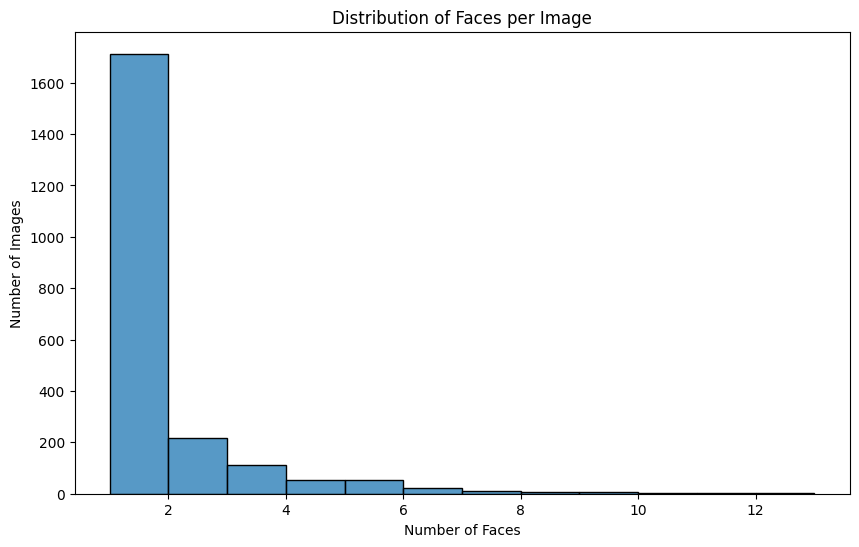

In [90]:
# Visualize the distribution of face counts per image
plt.figure(figsize=(10, 6))
sns.histplot(faces_per_image['face_count'], bins=range(1, max_faces_per_image + 2), kde=False)
plt.title('Distribution of Faces per Image')
plt.xlabel('Number of Faces')
plt.ylabel('Number of Images')
plt.show()

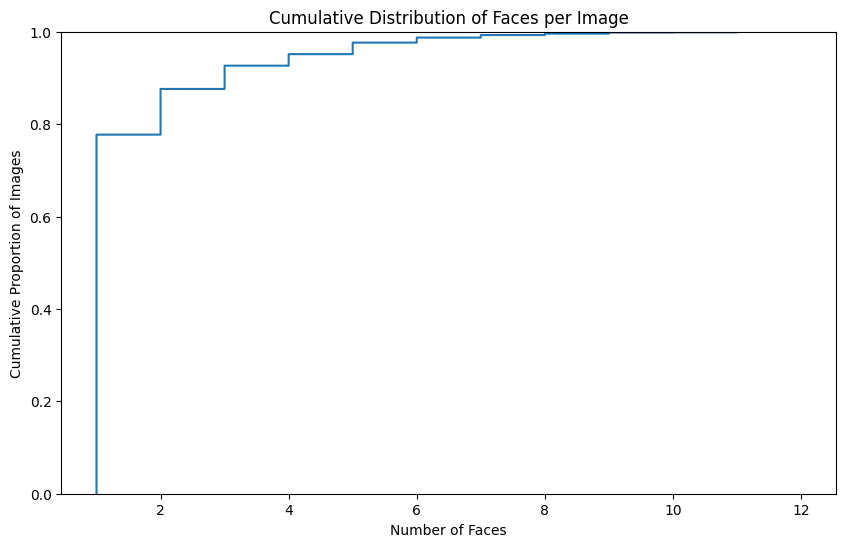

In [91]:
# Visualize the cumulative distribution of face counts per image
plt.figure(figsize=(10, 6))
sns.ecdfplot(faces_per_image['face_count'])
plt.title('Cumulative Distribution of Faces per Image')
plt.xlabel('Number of Faces')
plt.ylabel('Cumulative Proportion of Images')
plt.show()

In [65]:
# Split the data
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

# Verify the split
print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 2680
Test set size: 670


In [66]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Transfer learning (using pretrained model Restnet50)
re_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    # input_tensor=None,
    input_shape=(224,224,3)
)

In [67]:
#creating the model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, BatchNormalization, Flatten,AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model

# Build the model
x = re_model.output
x = GlobalAveragePooling2D()(x)  # Use GlobalAveragePooling2D to reduce dimensions
x = Dense(250, activation="relu")(x)
x = Dense(250, activation="relu")(x)
output = Dense(4, activation="linear")(x)  # Assuming 4 output classes or regression outputs
model = Model(inputs=re_model.input, outputs=output)

In [69]:
# Compile the model
model.compile(optimizer='adam',
              loss='mean_squared_error',  # Adjust based on your specific problem
              metrics=['accuracy'])

In [72]:
# Print the model summary
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,163,716 (92.18 MB)

 Trainable params: 24,110,596 (91.97 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [73]:
# Create datasets
train_dataset = to_dataset(train_df)
test_dataset = to_dataset(test_df)

In [74]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=2,  # Adjust based on your needs
    verbose=1
)

Epoch 1/2
84/84 ━━━━━━━━━━━━━━━━━━━━ 501s 6s/step - accuracy: 0.5790 - loss: 0.3781 - val_accuracy: 0.7955 - val_loss: 0.0725
Epoch 2/2
84/84 ━━━━━━━━━━━━━━━━━━━━ 502s 6s/step - accuracy: 0.7407 - loss: 0.0236 - val_accuracy: 0.7955 - val_loss: 0.0525


In [75]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7988 - loss: 0.0523
Test Loss: 0.052540093660354614
Test Accuracy: 0.7955223917961121


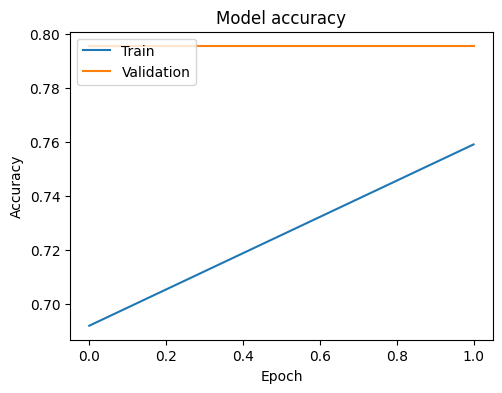

In [93]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

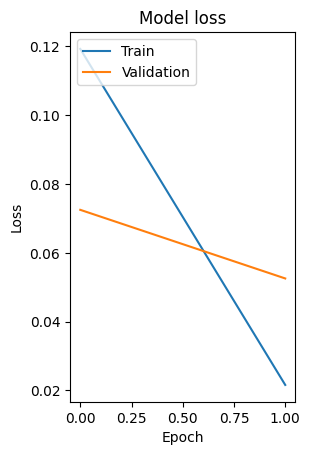

In [94]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [78]:
from sklearn.metrics import precision_recall_fscore_support

# Make predictions on the test dataset
y_true = []
y_pred = []

for image, label in test_dataset.unbatch():
    y_true.append(label.numpy())
    y_pred.append(model.predict(tf.expand_dims(image, axis=0)).flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━

In [80]:
# Calculate Mean Squared Error (MSE)
from sklearn.metrics import mean_squared_error

y_true_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()
mse = mean_squared_error(y_true_flat, y_pred_flat)
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 0.0525400962889066


In [81]:
# Calculate Intersection over Union (IoU)
def calculate_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1g, y1g, x2g, y2g = box2

    xi1, yi1, xi2, yi2 = max(x1, x1g), max(y1, y1g), min(x2, x2g), min(y2, y2g)
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2g - x1g) * (y2g - y1g)

    union_area = box1_area + box2_area - inter_area
    iou = inter_area / union_area
    return iou

ious = []
for i in range(len(y_true)):
    iou = calculate_iou(y_true[i], y_pred[i])
    ious.append(iou)

mean_iou = np.mean(ious)
print(f"Mean Intersection over Union (IoU): {mean_iou}")

Mean Intersection over Union (IoU): 0.05763758598919952


In [82]:
# Save the model in the native Keras format
model.save("my_model.keras")

In [83]:
def preprocessing(file_path, label, pred=False):
    img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(img, channels=3)
    height_img = img.shape[0]
    width_img = img.shape[1]
    img = tf.image.resize(img, [224, 224])
    img = tf.cast(img, tf.float32) / 255.0
    if pred:
        return img, width_img, height_img
    return img, label

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


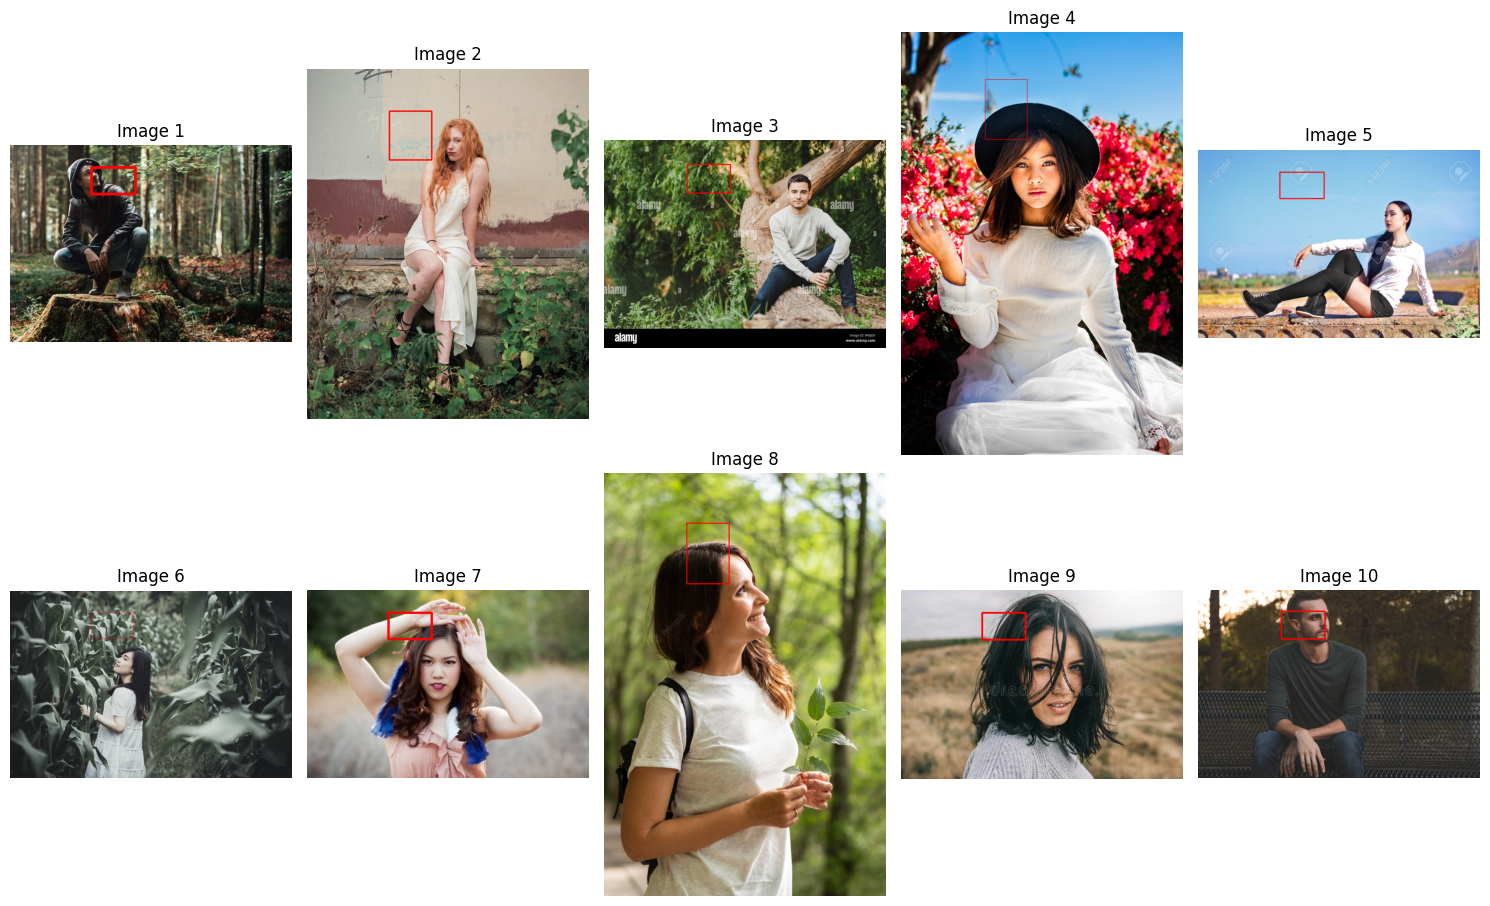

In [95]:
def predict_and_visualize_multiple(img_paths):
    plt.figure(figsize=(15, 10))

    for i, img_path in enumerate(img_paths):
        # Preprocess image
        test_img, width, height = preprocessing(img_path, None, pred=True)
        test_img = tf.reshape(test_img, (1, 224, 224, 3))

        # Make prediction
        pred = model.predict(test_img)

        # Read the image
        imr = cv2.imread(img_path)
        imr = cv2.cvtColor(imr, cv2.COLOR_BGR2RGB)  # Convert to RGB

        # Scale predictions back to original image dimensions
        x0 = int(pred[0][0] * width)
        y0 = int(pred[0][1] * height)
        x1 = int(pred[0][2] * width)
        y1 = int(pred[0][3] * height)

        # Draw rectangle on image
        p1 = (x0, y0)
        p2 = (x1, y1)
        color = (255, 0, 0)
        thickness = 3
        cv2.rectangle(imr, p1, p2, color, thickness)

        # Display the image in a grid
        plt.subplot(2, 5, i + 1)  # Adjust grid size based on the number of images
        plt.imshow(imr)
        plt.axis('off')
        plt.title(f'Image {i + 1}')

    plt.tight_layout()
    plt.show()

# Example usage with the first 10 images
image_folder = 'images'
image_files = os.listdir(image_folder)
image_paths = [os.path.join(image_folder, img_file) for img_file in image_files[:10]]  # Adjust range as needed

predict_and_visualize_multiple(image_paths)